# Setup

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import time
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)
from xgboost import XGBClassifier

SEED = 2024

# Data preparation

In [2]:
data = pd.read_csv('/kaggle/input/predict-online-course-engagement-dataset/online_course_engagement_data.csv')

In [3]:
TARGET = 'CourseCompletion'
features = [f for f in data.columns if f not in ('UserID', TARGET)]
cat_features = ['DeviceType', 'CourseCategory']
num_features = [f for f in features if f not in cat_features]

### Preprocessing

In [4]:
def preprocess_dataset(df):
    # remove duplicates
    df = df.drop_duplicates(ignore_index=True)
    
    # one-hot encoding nominal variable
    df = pd.get_dummies(df, columns=['CourseCategory'], dtype='category')
    
    df['DeviceType'] = df['DeviceType'].astype('category')
    
    # binarize numerical features
    df['time_spent_above_threshold'] = (df['TimeSpentOnCourse'] > 20).astype('category')
    df['num_videos_above_threshold'] = (df['NumberOfVideosWatched'] > 5).astype('category')
    df['num_quizzes_above_threshold'] = (df['NumberOfQuizzesTaken'] > 3).astype('category')
    df['quiz_scores_above_threshold'] = (df['QuizScores'] > 68).astype('category')
    df['completion_above_threshold'] = (df['CompletionRate'] > 60).astype('category')
    
    return df

In [5]:
data = preprocess_dataset(data.copy())

### Feature sets

In [6]:
original_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science'
]

extended_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science', 
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

binary_features = [
    'DeviceType', 'CourseCategory_Arts', 'CourseCategory_Business', 
    'CourseCategory_Health', 'CourseCategory_Programming', 
    'CourseCategory_Science', 'time_spent_above_threshold', 
    'num_videos_above_threshold', 'num_quizzes_above_threshold', 
    'quiz_scores_above_threshold', 'completion_above_threshold'
]

minimal_features = [
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

In [7]:
feature_sets = {
    'Original': original_features,
    'Extended': extended_features,
    'Binary': binary_features,
    'Minimal': minimal_features
}

### Holdout set for model-testing

In [8]:
train, test, _, _ = train_test_split(
    data, data[TARGET],
    stratify=data[TARGET],
    test_size=0.1,  # same size
    shuffle=True,
    random_state=SEED  # same sampling
)

# Modeling framework

In [9]:
def cross_validate(estimator, feature_set, verbose=True, num_folds=9):
    global train, test, TARGET
    
    scores_auc, scores_acc = [], []
    X, y = train[feature_set], train[TARGET]
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        model = clone(estimator)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        probs = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, probs)
        scores_auc.append(auc)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        scores_acc.append(acc)
        
        if verbose:
            print(f'Fold #{fold}: Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f} ({model.best_iteration:>4} rounds)')
        
    print(f'\nAvg. Accuracy: {np.mean(scores_acc):.4f} +/- {np.std(scores_acc):.4f}')
    print(f'Avg. ROC-AUC: {np.mean(scores_auc):.4f} +/- {np.std(scores_auc):.4f}\n')

In [10]:
def refit_full_and_evaluate(model, feature_set):
    global train, test, TARGET    
    
    X_train, X_val, y_train, y_val = train_test_split(
        train[feature_set], train[TARGET], 
        test_size=0.05, # just for early stopping check
        stratify=train[TARGET],
        shuffle=True, 
        random_state=SEED
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    probs = model.predict_proba(test[feature_set])[:, 1]
    preds = model.predict(test[feature_set])
    accuracy = accuracy_score(test[TARGET], preds)
    auc = roc_auc_score(test[TARGET], probs)
    print(f'|| Accuracy: {accuracy:.4f} || ROC-AUC: {auc:.4f} ||\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], preds, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()
    
    return model

In [11]:
def save_model(model, config, notebook='03'):
    save_path = f'{notebook}_{config}.joblib'
    joblib.dump(model, save_path)

In [12]:
def run_experiment(estimator, model_name, verbose=True, save=True):
    global feature_sets
    
    for fname, fset in feature_sets.items():
        print('\n', '-'*25, fname, '-'*25)
        start_time = time.time()
        print('Cross-validation:')
        cross_validate(estimator, fset, verbose)
        print('Refit to full training data and evaluate:\n')
        model = refit_full_and_evaluate(estimator, fset)
        end_time = time.time()
        print(f'\n(Time taken: {end_time - start_time:.2f} secs)')
        
        if save:
            save_model(model, f'{model_name}_{fname}')

# Experiments

In [13]:
class_ratio = train[TARGET].value_counts()[1] / train[TARGET].value_counts()[0]

PARAMS = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'scale_pos_weight': class_ratio,
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'early_stopping_rounds': 100,
    'device': 'cpu',
    'enable_categorical': True,
    'max_cat_to_onehot': 2,
    'verbosity': 0,
    'n_jobs': None,
    'seed': SEED
}


 ------------------------- Original -------------------------
Cross-validation:

Avg. Accuracy: 0.9564 +/- 0.0076
Avg. ROC-AUC: 0.9544 +/- 0.0070

Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9599 ||



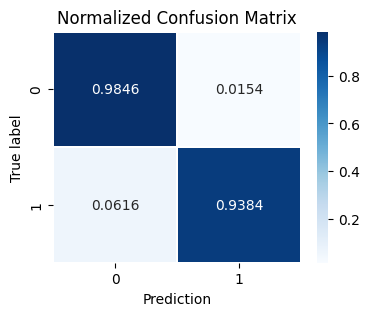


(Time taken: 4.19 secs)

 ------------------------- Extended -------------------------
Cross-validation:

Avg. Accuracy: 0.9575 +/- 0.0075
Avg. ROC-AUC: 0.9540 +/- 0.0085

Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9599 ||



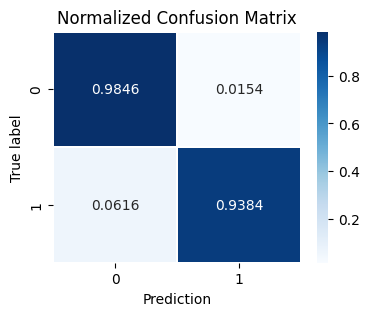


(Time taken: 4.09 secs)

 ------------------------- Binary -------------------------
Cross-validation:

Avg. Accuracy: 0.9431 +/- 0.0081
Avg. ROC-AUC: 0.9457 +/- 0.0108

Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9490 ||



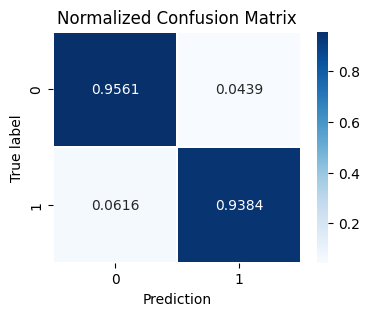


(Time taken: 3.16 secs)

 ------------------------- Minimal -------------------------
Cross-validation:

Avg. Accuracy: 0.9431 +/- 0.0081
Avg. ROC-AUC: 0.9456 +/- 0.0109

Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9497 ||



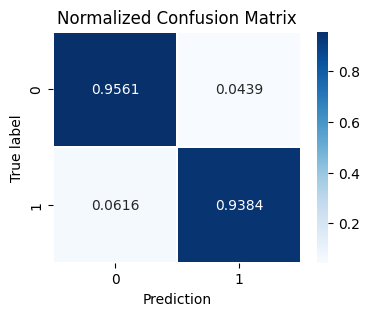


(Time taken: 2.44 secs)


In [14]:
model = XGBClassifier(**PARAMS)

run_experiment(model, 'xgb', verbose=False)